In [1]:
import torch
import os
import random
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm, trange
from torchvision import transforms, datasets
from shutil import copyfile, move
from torch.utils.tensorboard import SummaryWriter
from barbar import Bar
from torchsummary import summary
from ignite.metrics import Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when monitored metric decrease.'''
        if self.verbose:
            self.trace_func(f'Monitored metric has improved ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'./content/skinmodel50.pt') 
        self.val_loss_min = val_loss

In [3]:
def split_data(source, training, validation, split_size):    
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * split_size)
    validation_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[:validation_length]

    for filename in training_set:
        this_file = source + filename
        destination = training + filename
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = source + filename
        destination = validation + filename
        copyfile(this_file, destination)

In [5]:
#!unzip /content/drive/MyDrive/Skin.zip -d /content

In [6]:
os.mkdir('./content/orig/')
os.mkdir('./content/orig/0.MEL/')
os.mkdir('./content/orig/1.NV/')
os.mkdir('./content/orig/2.BCC/')
os.mkdir('./content/orig/3.AKIEC/')
os.mkdir('./content/orig/4.BKL/')
os.mkdir('./content/orig/5.DF/')
os.mkdir('./content/orig/6.VASC/')

os.mkdir('./content/skin/')
os.mkdir('./content/skin/training/')
os.mkdir('./content/skin/validation/')
os.mkdir('./content/skin/training/0.MEL/')
os.mkdir('./content/skin/training/1.NV/')
os.mkdir('./content/skin/training/2.BCC/')
os.mkdir('./content/skin/training/3.AKIEC/')
os.mkdir('./content/skin/training/4.BKL/')
os.mkdir('./content/skin/training/5.DF/')
os.mkdir('./content/skin/training/6.VASC/')
os.mkdir('./content/skin/validation/0.MEL/')
os.mkdir('./content/skin/validation/1.NV/')
os.mkdir('./content/skin/validation/2.BCC/')
os.mkdir('./content/skin/validation/3.AKIEC/')
os.mkdir('./content/skin/validation/4.BKL/')
os.mkdir('./content/skin/validation/5.DF/')
os.mkdir('./content/skin/validation/6.VASC/')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './content/orig/'

In [4]:
orig_all = './data/HAM10000/'
source_MEL = './content/orig/0.MEL/'
source_NV = './content/orig/1.NV/'
source_BCC = './content/orig/2.BCC/'
source_AKIEC = './content/orig/3.AKIEC/'
source_BKL = './content/orig/4.BKL/'
source_DF = './content/orig/5.DF/'
source_VASC = './content/orig/6.VASC/'

In [5]:

training_MEL = './content/skin/training/0.MEL/'
training_NV = './content/skin/training/1.NV/'
training_BCC = './content/skin/training/2.BCC/'
training_AKIEC = './content/skin/training/3.AKIEC/'
training_BKL = './content/skin/training/4.BKL/'
training_DF = './content/skin/training/5.DF/'
training_VASC = './content/skin/training/6.VASC/'
validation_MEL = './content/skin/validation/0.MEL/'
validation_NV = './content/skin/validation/1.NV/'
validation_BCC = './content/skin/validation/2.BCC/'
validation_AKIEC = './content/skin/validation/3.AKIEC/'
validation_BKL = './content/skin/validation/4.BKL/'
validation_DF = './content/skin/validation/5.DF/'
validation_VASC = './content/skin/validation/6.VASC/'

In [8]:
data = pd.read_csv(r'./HAM10000_metadata.csv')

In [18]:
pd.unique(data['dx'])

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [21]:
for index, image in enumerate(image_names):
    image = image + '.jpg'
    if diagnosis[index] == 'mel':
        copyfile(os.path.join(orig_all, image), os.path.join(source_MEL, image))
    elif diagnosis[index] == 'nv':
        copyfile(os.path.join(orig_all, image), os.path.join(source_NV, image))
    elif diagnosis[index] == 'bcc': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_BCC, image))
    elif diagnosis[index] == 'akiec': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_AKIEC, image))
    elif diagnosis[index] == 'bkl':
        copyfile(os.path.join(orig_all, image), os.path.join(source_BKL, image))
    elif diagnosis[index] == 'df':  
        copyfile(os.path.join(orig_all, image), os.path.join(source_DF, image))
    elif diagnosis[index] == 'vasc': 
        copyfile(os.path.join(orig_all, image), os.path.join(source_VASC, image))            

In [23]:
split_size = 0.8
split_data(source_MEL, training_MEL, validation_MEL, split_size)
split_data(source_NV, training_NV, validation_NV, split_size)
split_data(source_BCC, training_BCC, validation_BCC, split_size)
split_data(source_AKIEC, training_AKIEC, validation_AKIEC, split_size)
split_data(source_BKL, training_BKL, validation_BKL, split_size)
split_data(source_DF, training_DF, validation_DF, split_size)
split_data(source_VASC, training_VASC, validation_VASC, split_size)

In [2]:
traindir = r'./content/skin/training/'
valdir = r'./content/skin/validation/'

In [10]:
#traindir = './data/model/training/'
#valdir = './data/model/validation/'
#testdir = './data/model/test/'

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(
    traindir, transform=train_transforms)

val_dataset = datasets.ImageFolder(
    valdir, transform=val_transforms)

In [4]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

In [5]:
class_weights = [1.7380176826430898, 0.197509320218926, 3.2634338138925294,
4.680451127819549, 1.467871880526626, 14.61839530332681, 10.889212827988338] 
class_weights_tensor = torch.Tensor(class_weights)
print(f"Weights of the classes {class_weights}")

Weights of the classes [1.7380176826430898, 0.197509320218926, 3.2634338138925294, 4.680451127819549, 1.467871880526626, 14.61839530332681, 10.889212827988338]


In [6]:
print(val_dataset.class_to_idx)
print(train_dataset.class_to_idx)

{'0.MEL': 0, '1.NV': 1, '2.BCC': 2, '3.AKIEC': 3, '4.BKL': 4, '5.DF': 5, '6.VASC': 6}
{'0.MEL': 0, '1.NV': 1, '2.BCC': 2, '3.AKIEC': 3, '4.BKL': 4, '5.DF': 5, '6.VASC': 6}


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
model = torchvision.models.resnet50(pretrained=True).to(device)

model.fc = nn.Linear(2048, 7).to(device)

criterion = nn.CrossEntropyLoss()#weight=class_weights_tensor.to(device))

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)

writer = SummaryWriter(log_dir='./content/', filename_suffix="skin50")

In [19]:
model = torch.load('./model_150e_tv.pth')

In [22]:
#model.load_state_dict(torch.load('./weights/lesion_classifier_250e_ttv.pt'))

In [16]:
# Sets the early stopping point, if the Loss function plateaus, the model stops training and saves the last set of weights. 
#early_stopping = EarlyStopping(patience=50, verbose=True)

# Saves the accuracy over the course of the training
train_accuracy_list = []
val_accuracy_list = []

# Saves the loss values over the course of the training
train_loss_list = []
val_loss_list = []

In [20]:
epochs = 50

In [ ]:
for epoch in range(epochs):
    
    train_loss = 0.00
    val_loss = 0.00
    
    train_accuracy = Accuracy()
    val_accuracy = Accuracy()
    

    
    print(f'Epoch {epoch+1}')

    # Training loop
    for idx, (inputs, labels) in enumerate(Bar(train_loader)):
        model.train()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()
        train_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))
      
    train_acc = train_accuracy.compute()
    train_accuracy_list.append(train_acc) 
    print(f"Train Accuracy: {train_acc}")
    train_loss /= len(train_loader)
    train_loss_formated = "{:.4f}".format(train_loss)
    train_loss_list.append(train_loss_formated)
    
    # Validation loop
    with torch.no_grad():
        for inputs, labels in val_loader:
            model.eval()           
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))
            
    val_acc = val_accuracy.compute()
    val_accuracy_list.append(val_acc)
    print(f"Val Accuracy: {val_acc}")
    val_loss /= len(val_loader)
    val_loss_formated = "{:.4f}".format(val_loss)
    val_loss_list.append(val_loss_formated)
    print(f'Training Loss: {train_loss_formated}')
    print(f"Validation Loss: {val_loss_formated}")

    # TensorBoard writer 
    writer.add_scalar('Loss/train', train_loss, epoch+1)
    writer.add_scalar('Loss/val', val_loss, epoch+1)
    writer.add_scalar('Accuracy/train', train_accuracy.compute(), epoch+1)
    writer.add_scalar('Accuracy/val', val_accuracy.compute(), epoch+1)

    ## Early Stopping
    #early_stopping(val_loss, model)       
    #if early_stopping.early_stop:
    #    print("Early stopping")
    #    break

Epoch 1
5973/5973: [===============================>] - ETA 0.6ss
Train Accuracy: 0.9712037502092751
Val Accuracy: 0.9819639278557114
Training Loss: 0.0849
Validation Loss: 0.0518
Epoch 2
5973/5973: [===============================>] - ETA 0.7ss
Train Accuracy: 0.974049891176963
Val Accuracy: 0.9826319305277221
Training Loss: 0.0807
Validation Loss: 0.0534
Epoch 3
5973/5973: [===============================>] - ETA 0.7ss
Train Accuracy: 0.9728779507785033
Val Accuracy: 0.9839679358717435
Training Loss: 0.0815
Validation Loss: 0.0540
Epoch 4
5973/5973: [===============================>] - ETA 0.7ss
Train Accuracy: 0.9713711702661979
Val Accuracy: 0.9819639278557114
Training Loss: 0.0865
Validation Loss: 0.0566
Epoch 5
5973/5973: [===============================>] - ETA 0.7ss
Train Accuracy: 0.9735476310061946
Val Accuracy: 0.9819639278557114
Training Loss: 0.0803
Validation Loss: 0.0576
Epoch 6
 512/5973: [==>.............................] - ETA 55.5s

In [ ]:
results_df = pd.DataFrame()
results_df['train_loss'] = train_loss_list
results_df['val_loss'] = val_loss_list
results_df['train_acc'] = train_accuracy_list
results_df['val_acc'] = val_accuracy_list
results_df.head(3)

In [18]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc, val_acc):
    """
    Plots the accuracy over the course of training.

    Args:
        train_acc (list): List of training accuracies for each epoch.
        val_acc (list): List of validation accuracies for each epoch.
    """
    epochs = len(train_acc)
    plt.plot(range(1, epochs + 1), train_acc, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Training')
    plt.legend()
    plt.show()

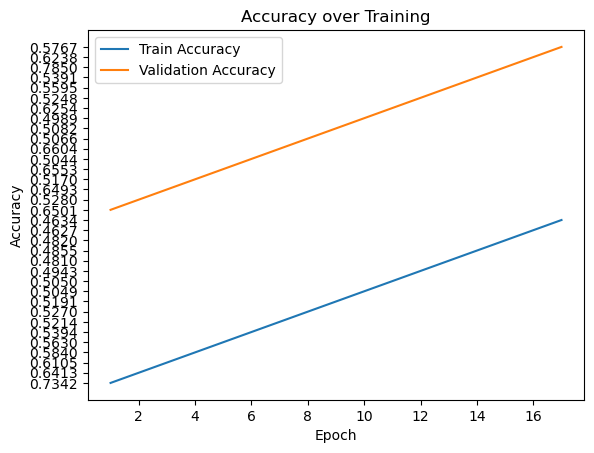

In [21]:
plot_accuracy(results_df['train_loss'], results_df['val_loss'])

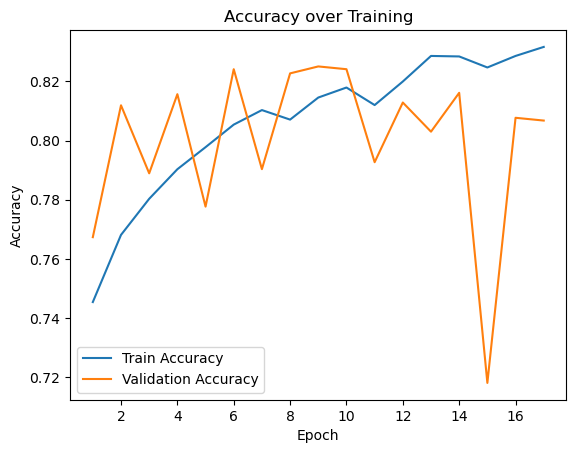

In [22]:
plot_accuracy(results_df['train_acc'], results_df['val_acc'])

In [47]:
#torch.save(model, './content/model_100e_tv.pth')

In [48]:
#torch.save(model.state_dict(), f'./content/skinmodel50.pt')

In [30]:
# load the last checkpoint with the best model
#model.load_state_dict(torch.load('./content/')) 

In [ ]:


def evaluate_sample(image, model, label_mapping):
    """
    Evaluates an individual sample and outputs the predicted label.

    Args:
        image (torch.Tensor): Input image tensor.
        model (torch.nn.Module): Trained model.
        label_mapping (list): List of class label mappings.

    Returns:
        str: Predicted label for the input sample.
    """
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        probabilities = nn.functional.softmax(output, dim=1)
        _, predicted = torch.max(probabilities, 1)
        predicted_label = label_mapping[predicted.item()]
        return predicted_label

              precision    recall  f1-score   support

         mel       0.96      0.91      0.93       123
          nv       0.99      1.00      0.99      1081
         bcc       0.98      0.95      0.97        66
       akiec       0.88      0.98      0.93        46
         bkl       0.97      0.97      0.97       146
          df       1.00      0.87      0.93        15
        vasc       1.00      1.00      1.00        20

    accuracy                           0.98      1497
   macro avg       0.97      0.95      0.96      1497
weighted avg       0.98      0.98      0.98      1497

AUC of class mel = 0.9987278257062047
AUC of class nv = 0.9993106454137907
AUC of class bcc = 0.99995764775639
AUC of class akiec = 0.9995954813771613
AUC of class bkl = 0.9989252000040559
AUC of class df = 0.9999100314889788
AUC of class vasc = 1.0


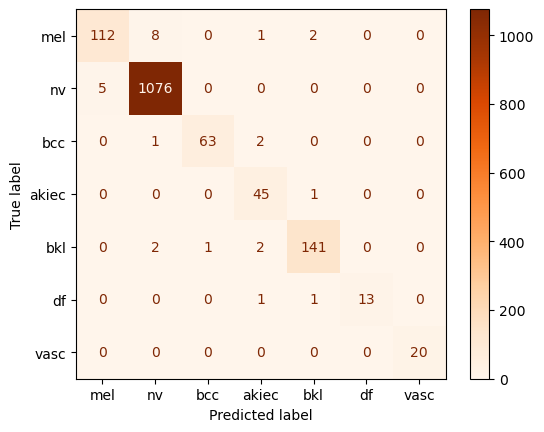

In [33]:
num_classes = 7

predlist = torch.zeros(0,dtype=torch.long, device='cpu')
lbllist = torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        model.eval()
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
        predlistauc = torch.cat([predlistauc,nn.functional.softmax(outputs, dim=1).cpu()])
        
predlist = predlist.numpy()
lbllist = lbllist.numpy()
predlistauc = predlistauc.numpy()

# Confusion matrix, classification report and AUC
conf_mat=confusion_matrix(lbllist, predlist)
target_names = ['mel','nv','bcc','akiec','bkl','df','vasc',]
ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d", cmap='Oranges')
print(classification_report(lbllist, predlist, target_names=target_names))
lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
                                          predlistauc, multi_class='ovr', average=None)
for i, every in enumerate(target_names):
    print(f'AUC of class {every} = {every_auc[i]}')

              precision    recall  f1-score   support

         mel       0.96      0.91      0.93       615
          nv       0.99      1.00      0.99      5405
         bcc       0.98      0.95      0.97       330
       akiec       0.88      0.98      0.93       230
         bkl       0.97      0.97      0.97       730
          df       1.00      0.87      0.93        75
        vasc       1.00      1.00      1.00       100

    accuracy                           0.98      7485
   macro avg       0.97      0.95      0.96      7485
weighted avg       0.98      0.98      0.98      7485

AUC of class mel = 0.9987278257062047
AUC of class nv = 0.9993106454137904
AUC of class bcc = 0.9999576477563898
AUC of class akiec = 0.9995954813771613
AUC of class bkl = 0.9989252000040558
AUC of class df = 0.999910031488979
AUC of class vasc = 1.0


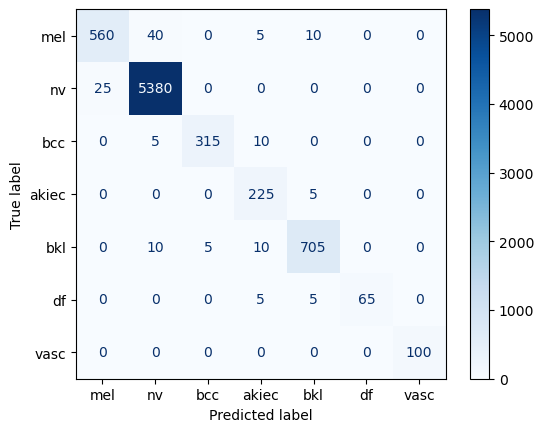

In [34]:
num_classes = 7

predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
predlistauc = torch.zeros(0,dtype=torch.long, device='cpu')
for n in range(5):
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            model.eval()
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
            predlistauc = torch.cat([predlistauc,nn.functional.softmax(outputs, dim=1).cpu()])
            
predlist = predlist.numpy()
lbllist = lbllist.numpy()
predlistauc = predlistauc.numpy() 

# Confusion matrix, classification report and AUC
conf_mat=confusion_matrix(lbllist, predlist)
target_names = ['mel','nv','bcc','akiec','bkl','df','vasc',]
ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d", cmap='Blues')
print(classification_report(lbllist, predlist, target_names=target_names))
lbllist_one_hot = nn.functional.one_hot(torch.tensor([lbllist]), num_classes=num_classes)
every_auc = roc_auc_score(lbllist_one_hot.view([predlistauc.shape[0], predlistauc.shape[1]]), 
                                          predlistauc, multi_class='ovr', average=None)
for i, every in enumerate(target_names):
    print(f'AUC of class {every} = {every_auc[i]}')